## CS6482 Deep Reinforcement Learning : Assignment 1


## Student 1 Name : Daniel Maguire
## Student 1 ID : 23222425

## Student 2 Name : Malik E Ashtar
## Student 2 ID : 23044004

The code in this notebook runs to the end without error

Original Source of MobileNetV3 implementation: https://github.com/Syavaprd/mobilenet_v3/blob/master/run.py

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
from os import environ
from os.path import abspath, dirname, join
import glob
from PIL import Image
from torch.utils.data.dataset import random_split
from torch.utils.data import DataLoader
import numpy as np
import os
from torchvision.utils import make_grid
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.metrics import precision_score, recall_score, accuracy_score

Here we are just trying to set the device to be used to be the the GPU if possible

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


### Tranformations of the data
Transformations for data preprocessing: resizing images to 224x224, converting them to tensors, and normalising them
I have also applied some random flipping and rotations of the training data to help the model generalise better.

This augmentation is applied only to the training dataset to avoid accidently increasing the model's performance metrics on the validation and test sets.

We also split the dataset into training, validation, and test sets here

In [ ]:
def load_split_train_test(datadir, valid_size=.2, batch_size=64):
    #Transformations for training data
    #Resizing to 224x224 to match the required size of the input layer of the model
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        #Randomly flip images horizontally
        transforms.RandomHorizontalFlip(),
        #Randomly rotate images by up to 10 degrees
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #Transformations for validation/test data
    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #Loading CIFAR10 dataset with train/test splits and applying the above transformations
    train_data = torchvision.datasets.CIFAR10(datadir, train=True, download=True, transform=train_transform)
    test_data = torchvision.datasets.CIFAR10(datadir, train=False, download=True, transform=test_transform)

    #Calculate sizes for splitting training data into training and validation sets
    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))

    np.random.shuffle(indices)

    train_idx, valid_idx = indices[split:], indices[:split]

    # Creating data subsets for training and validation
    train_subset = torch.utils.data.Subset(train_data, train_idx)
    valid_subset = torch.utils.data.Subset(train_data, valid_idx)

    # DataLoader objects for loading the actual batches of data
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    valid_loader = DataLoader(valid_subset, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True, num_workers=2)

    return train_loader, valid_loader, test_loader


In [ ]:
def plot_true_label_distribution(test_loader, dataset_name):
    all_true_labels = []

    #Collect all true labels
    for _, labels in test_loader:
        all_true_labels.extend(labels.numpy())

    #Convert to numpy array for easier manipulation
    all_true_labels = np.array(all_true_labels)

    #Count the frequency of each class
    unique_labels, counts = np.unique(all_true_labels, return_counts=True)

    plt.figure(figsize=(10, 6))
    plt.bar(unique_labels, counts, tick_label=unique_labels)
    plt.xlabel('Class Labels')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of True Labels in {dataset_name} Dataset')
    plt.xticks(unique_labels)
    plt.grid(axis='y')

    plt.show()

### Here we are splitting the data into train / test / validation sets

In [ ]:
batch_size = 64
train_loader, valid_loader, test_loader = load_split_train_test('./data', valid_size=0.3, batch_size=batch_size)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
%matplotlib inline

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])

        #Denormalise images
        mean = torch.tensor([0.485, 0.456, 0.406])
        std = torch.tensor([0.229, 0.224, 0.225])
        images = images * std.view(1, 3, 1, 1) + mean.view(1, 3, 1, 1)

        #Clip pixel values to the valid range for imshow
        images = torch.clamp(images, 0, 1)

        #Display images
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

Here we are showing a sample of the training set. The rotation and flip transformations that we applied are clearly visible

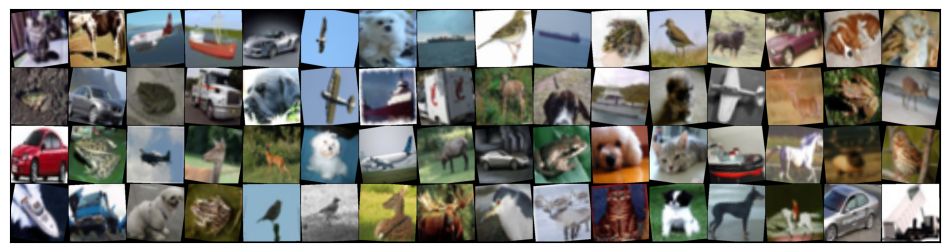

In [ ]:
show_batch(train_loader)

The plots below are to make sure that our data is correctly distributed. Unbalanced datasets end up being biased towards more frequent classes, so this is just a confirmation step.

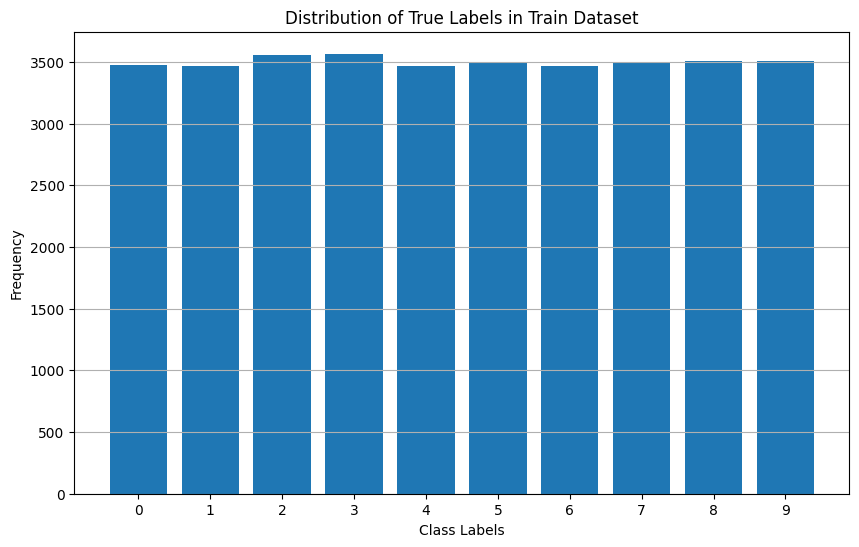

In [ ]:
plot_true_label_distribution(train_loader, "Train")

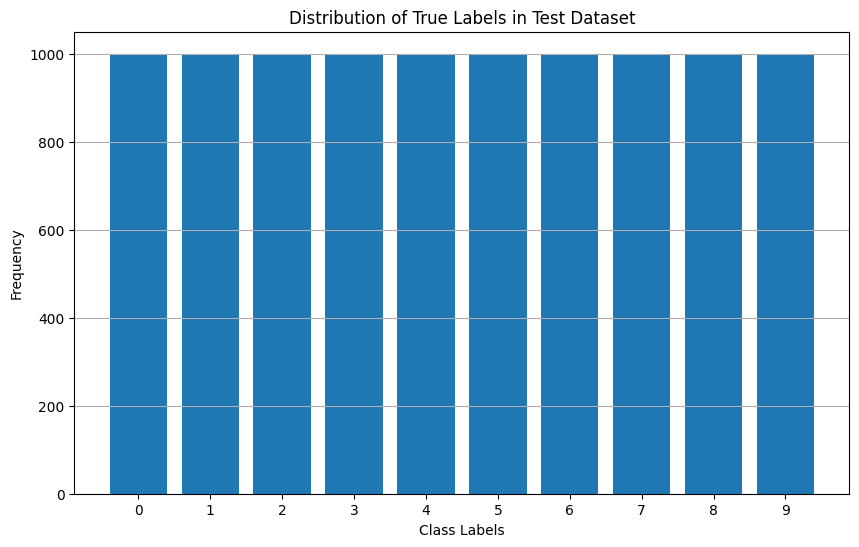

In [ ]:
plot_true_label_distribution(test_loader, "Test")

It is clear that we have a balanced training and test dataset here, so we can move forward.

## HardSigmoid activation function

In [ ]:
class HardSigmoid(nn.Module):
    def __init__(self):
        super(HardSigmoid, self).__init__()

    def forward(self, x):
        #Applies the Hard Sigmoid activation
        return F.relu6(x + 3.) / 6.

## HardSwish activation function

In [ ]:
class HardSwish(nn.Module):
    def __init__(self):
        super(HardSwish, self).__init__()

    def forward(self, x):
        #Applies Hard Swish activation
        return x * F.relu6(x + 3.) / 6.

In [ ]:
##num parameters in a model
def countParams(model):
    return sum(p.numel() for p in model.parameters())

## Squeeze and Excitation block
Critical component in MobileNetV3. Allows the model to recalibrate channel wise feature responses.

In [ ]:
class SqueezeExcite(nn.Module):
    def __init__(self, exp_size, divide=4):
        super(SqueezeExcite, self).__init__()

        self.fc_R = nn.Sequential(
            nn.Linear(exp_size, exp_size // divide, bias=False),
            nn.ReLU()
        )

        self.fc_HS = nn.Sequential(
            nn.Linear(exp_size // divide, exp_size, bias=False),
            HardSigmoid()
        )

    def forward(self, x):
        batch, channels, height, width = x.size()
        #Global average pooling to squeeze spatial dimensions
        out = F.avg_pool2d(x, kernel_size=[height, width]).view(batch, -1)

        #Two fully connected layers with ReLU and Hard Sigmoid activations, respectively
        out = self.fc_R(out)
        out = self.fc_HS(out)

        #Reshape and scale the input feature map
        out = out.view(batch, channels, 1, 1)
        return out * x

## BottleNeck block
Fundamental building block for MobileNetV3, incorporating depthwise separable convolutions, SE blocks, and a choice of activation functions.

In [ ]:
class BottleNeck(nn.Module):
    def __init__(self, inp, out, exp, kernal_size, NL, SE, stride):
        super(BottleNeck, self).__init__()
        self.SE = SE

        #Padding calculation for depthwise convolution
        padding = 0
        if kernal_size == 3:
            padding = 1
        elif kernal_size == 5:
            padding = 2
        else:
            assert False, "Unsupported kernel size"

        #Activation function selection based on NL argument
        if NL == "ReLu":
            activation = nn.ReLU
        elif NL == "h_swish":
            activation = HardSwish
        else:
            assert False, "Unsupported non-linearity"

        #First 1x1 convolution for expanding the number of channels
        self.conv1 = nn.Sequential(
            nn.Conv2d(inp, exp, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(exp),
            activation()
        )

        #Depthwise convolution for spatial filtering
        self.dconv1 = nn.Sequential(
            nn.Conv2d(exp, exp, kernel_size=kernal_size, stride=stride, padding=padding, groups=exp, bias=False),
            nn.BatchNorm2d(exp),
        )

        #Squeeze-and-Excitation block, if SE is True
        self.squeeze = SqueezeExcite(exp) if SE else nn.Identity()

        #Second 1x1 convolution for reducing the number of channels to the desired output size
        self.conv2 = nn.Sequential(
            nn.Conv2d(exp, out, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out),
            activation()
        )

        #Connection flag for choosing whether to use residual connections
        self.connect_flag = (stride == 1 and inp == out)

    def forward(self, x):
        x2 = self.conv1(x)
        x2 = self.dconv1(x2)

        if self.SE:
            x2 = self.squeeze(x2)

        x2 = self.conv2(x2)

        #Apply residual connection if needed
        if self.connect_flag:
            return x + x2
        else:
            return x2

## MobileNetV3 class

with options for the number of output classes, dropout rate, and whether to use the large model configuration.

In [ ]:
class mobilenet_v3(nn.Module):
    def __init__(self, num_classes=10, dropout_rate=0.0, large=False):
        super(mobilenet_v3, self).__init__()
        self.num_classes = num_classes
        #This initial convolution layer reduces the spatial dimensions and changes the depth to
        #16 channels using a 3x3 kernel, followed by batch normalisation and the HardSwish activation
        self.conv1 = nn.Sequential(
                nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=2, padding=1),
                nn.BatchNorm2d(16),
                HardSwish(),
        )

        #Dynamically builds the architecture using bottleneck blocks, each defined by specific parameters
        #such as input/output channels, expansion size, kernel size, nonlinear activations,
        #use of Squeeze and Excite blocks and stride for down sampling
        self.body = []

        if large == True:
            print("Large model\n")
            layers = [
                [16, 16, 16, 3, "ReLu", False, 1],
                [16, 24, 64, 3, "ReLu", False, 2],
                [24, 24, 72, 3, "ReLu", False, 1],
                [24, 40, 72, 5, "ReLu", True, 2],
                [40, 40, 120, 5, "ReLu", True, 1],
                [40, 40, 120, 5, "ReLu", True, 1],
                [40, 80, 240, 3, "h_swish", False, 2],
                [80, 80, 200, 3, "h_swish", False, 1],
                [80, 80, 184, 3, "h_swish", False, 1],
                [80, 80, 184, 3, "h_swish", False, 1],
                [80, 112, 480, 3, "h_swish", True, 1],
                [112, 112, 672, 3, "h_swish", True, 1],
                [112, 160, 672, 5, "h_swish", True, 1],
                [160, 160, 960, 5, "h_swish", True, 2],
                [160, 160, 960, 5, "h_swish", True, 1],
            ]

            for inp, out, exp, kernal_size, NL, SE, stride in layers:
                self.body.append(BottleNeck(inp, out, exp, kernal_size, NL, SE, stride))

            #A 1x1 convolution that expands the feature map depth, followed by batch
            #normalisation and hard swish activation
            self.pconv2 = nn.Sequential(
                nn.Conv2d(160, 960, kernel_size=1, stride=1),
                nn.BatchNorm2d(960),
                HardSwish(),
            )
            #This is the final layer sequence which includes a 1x1 convolution that will further expand the features,
            #applies dropout for regularisation, and then reduces the depth to the number of classes for classification
            self.pconv3 = nn.Sequential(
                nn.Conv2d(960, 1280, kernel_size=1, stride=1),
                HardSwish(),
                nn.Dropout(p=dropout_rate),
                nn.Conv2d(1280, self.num_classes, kernel_size=1, stride=1),
            )

        else:
            print("Small model\n")
            layers = [
                [16, 16, 16, 3, "ReLu", True, 2],
                [16, 24, 72, 3, "ReLu", False, 2],
                [24, 24, 88, 3, "ReLu", False, 1],
                [24, 40, 96, 5, "ReLu", True, 2],
                [40, 40, 240, 5, "ReLu", True, 1],
                [40, 40, 240, 5, "ReLu", True, 1],
                [40, 48, 120, 5, "h_swish", True, 1],
                [48, 48, 144, 5, "h_swish", True, 1],
                [48, 96, 288, 5, "h_swish", True, 2],
                [96, 96, 576, 5, "h_swish", True, 1],
                [96, 96, 576, 5, "h_swish", True, 1],
            ]

            for inp, out, exp, kernal_size, NL, SE, stride in layers:
                self.body.append(BottleNeck(inp, out, exp, kernal_size, NL, SE, stride))

            self.pconv2 = nn.Sequential(
                nn.Conv2d(96, 576, kernel_size=1, stride=1),
                SqueezeExcite(576),
                nn.BatchNorm2d(576),
                HardSwish(),
            )

            self.pconv3 = nn.Sequential(
                nn.Conv2d(576, 1024, kernel_size=1, stride=1),
                HardSwish(),
                nn.Dropout(p=dropout_rate),
                nn.Conv2d(1024, self.num_classes, kernel_size=1, stride=1),
            )

        self.body = nn.Sequential(*self.body)

    #forward pass for the network, applying the initial convolution, bottleneck blocks,
    #second last convolution, global average pooling, and the final classification layer
    def forward(self, x):
        #Pass input through initial conv layer
        x = self.conv1(x)
        #Pass through the dynamically constructed body of bottleneck blocks
        x = self.body(x)
        #Pass through the second last conv layer
        x = self.pconv2(x)
        batch, _, h, w = x.size()
        #Global average pooling
        x = F.avg_pool2d(x, kernel_size=[h, w])
        #Final classification layer
        x = self.pconv3(x)
        #Flatten the output for classification
        x = x.view(batch, -1)
        return x

## Predict

In [ ]:
def predict(path, model):
    #Transformations to be applied to the input images
    #This includes resizing the image to 224x224, converting it to a tensor, and normalising it
    test_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    #Empty list to store the prediction outputs
    outputs = []

    #Temporarily set all the requires_grad flags to False,
    #indicating that we do not need to compute gradients, which is useful for inference.
    with torch.no_grad():
        #Loop over all images in the specified path with a .jpg extension
        for im_path in glob.glob(join(path, '*.jpg')):
            #Open image file
            image = Image.open(im_path)
            if image.mode != "RGB":
                #Skip images that are not in RGB format
                continue

            #Apply transforms and convert to float
            image_tensor = test_transforms(image).float()
            #Add batch dimension
            image_tensor = image_tensor.unsqueeze_(0)
            #Move the tensor to device (hopefully GPU)
            image_tensor = image_tensor.to(device)

            #Wrap the tensor in a Variable object
            input = Variable(image_tensor)
            #Perform a forward pass through the model
            output = model(input)

            #Extract predicted class index
            index = output.cpu().data.numpy().argmax()
            #Append predicted class index to output list
            outputs.append(index)
    #ReturnS list of predicted class indices
    return outputs

## Train

In [ ]:
def train(model, train_loader, valid_loader, epochs):
    #Define loss function, CrossEntropyLoss for classification
    criterion = nn.CrossEntropyLoss()
    #Define optimiser
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    #Learning rate scheduler
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.03)

    #Initialise lists to keep track of training and validation losses and accuracies
    train_losses, valid_losses = [], []
    train_accuracies, valid_accuracies = [], []

    #Loop over each epoch
    for epoch in range(epochs):
        #Set model to training mode, which enables dropout etc.
        model.train()
        running_loss, running_correct, running_total = 0.0, 0, 0  #Init metrics

        #Loop over each batch in the training set
        for inputs, labels in train_loader:
            #Move inputs and labels to device
            inputs, labels = inputs.to(device), labels.to(device)
            #Zero the gradients
            optimizer.zero_grad()
            #Forward pass
            outputs = model(inputs)
             #Calculate the loss
            loss = criterion(outputs, labels)
            #Backward pass
            loss.backward()
            #Update the model parameters
            optimizer.step()
            #Accumulate the loss
            running_loss += loss.item()
            #Get predictions
            _, predicted = torch.max(outputs.data, 1)
            #Calculate correct predictions
            running_correct += (predicted == labels).sum().item()
            #Count total number of labels
            running_total += labels.size(0)

        #Calculate and store training loss and accuracy for current epoch
        train_losses.append(running_loss/len(train_loader))
        train_accuracies.append(100.0 * running_correct / running_total)

        #Change model to evaluation mode
        model.eval()
        #Validation metrics
        val_loss, val_correct, val_total = 0.0, 0, 0

        #Loop over each batch in the validation set
        with torch.no_grad():
            for inputs, labels in valid_loader:
                #Move inputs and labels to the specified device
                inputs, labels = inputs.to(device), labels.to(device)
                 #Forward pass
                outputs = model(inputs)
                #Calc loss
                loss = criterion(outputs, labels)
                #Accumulate the validation loss
                val_loss += loss.item()
                #Get predictions
                _, predicted = torch.max(outputs.data, 1)
                #Calculate correct predictions
                val_correct += (predicted == labels).sum().item()
                #Count total number of labels
                val_total += labels.size(0)

        #Calc and store validation loss and accuracy for the current epoch
        valid_losses.append(val_loss/len(valid_loader))
        valid_accuracies.append(100.0 * val_correct / val_total)

        #summary
        print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]}, Valid Loss: {valid_losses[-1]}, '
              f'Train Accuracy: {train_accuracies[-1]}%, Valid Accuracy: {valid_accuracies[-1]}%')

        #Update learning rate
        scheduler.step()

    #Return model and collected data for plotting.
    return model, (train_losses, valid_losses, train_accuracies, valid_accuracies)

## Test

In [ ]:
def test(model, test_loader):
    all_preds = []
    all_true = []
    #Set model to evaluation mode
    #Disables dropout and batch normalisation layers
    model.eval()

    #count of correct predictions
    correct = 0
    #total count of labels
    total = 0

    #No gradient computation is needed because we are only making predictions not training
    with torch.no_grad():

        #Iterate over all batches in the test set
        for data in test_loader:
            #Unpack data. 'images' contains the input images and  'labels' contains the true labels
            images, labels = data
             #Move images and labels to device
            images, labels = images.to(device), labels.to(device)

            #Forward pass, computes the predicted outputs by passing images to the model
            outputs = model(images)

            #torch.max returns the maximum value of each row of the outputs tensor in the provided dimension
            #The second return value, 'predicted', is the index location of each maximum value found (argmax)
            _, predicted = torch.max(outputs.data, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_true.extend(labels.cpu().numpy())

            #Update total count of labels
            total += labels.size(0)
            #Compare predicted and true labels and update count of correct predictions
            correct += (predicted == labels).sum().item()

        #Calc precision, recall and accuracy
        precision = precision_score(all_true, all_preds, average='macro')
        recall = recall_score(all_true, all_preds, average='macro')
        accuracy = accuracy_score(all_true, all_preds)

        print(f'\nPrecision: {precision}')
        print(f'Recall: {recall}')
        print(f'Test Accuracy: {accuracy:.4f}')

In [ ]:
def plot_results(train_losses, valid_losses, train_accuracies, valid_accuracies, title):

    #Adjusting so the plot shows 1-5 rather than 0-4
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, valid_losses, label='Val Loss')
    plt.title(f'{title} Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, valid_accuracies, label='Val Accuracy')
    plt.title(f'{title} Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy percentage')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [ ]:
def plot_confusion_matrix(cm, class_names):
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

def get_all_preds_and_labels(loader, model, device):
    all_preds = []
    all_labels = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

## Function to train and test MobileNetV3

In [ ]:
def train_test_mobilenetV3(dropout_rate, epochs, large=True):
    #Init model with dropout rate, and set model size
    model = mobilenet_v3(dropout_rate=dropout_rate, large=large).to(device)

    #Train model
    _, metrics = train(model, train_loader, valid_loader, epochs)
    train_losses, valid_losses, train_accuracies, valid_accuracies = metrics
    #Test model
    test(model, test_loader)
    #Plot results
    title = f"Dropout {dropout_rate}, Epochs {epochs}"
    plot_results(train_losses, valid_losses, train_accuracies, valid_accuracies, title)

    #Predictions and true labels from validation set
    all_preds, all_labels = get_all_preds_and_labels(valid_loader, model, device)
    #Calculate the confusion matrix
    cm = confusion_matrix(all_labels, all_preds)

    #CIFAR-10 dataset class names
    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
    #Plot confusion matrix
    plot_confusion_matrix(cm, class_names)

###

## The Small Model

Optimal dropout rate that we found was 0.7 and the number of epochs is 4. If we add more epochs and we start to see early signs of overfitting.

Small model

Epoch 1, Train Loss: 1.6141414228261497, Valid Loss: 1.3722756355366807, Train Accuracy: 39.91428571428571%, Valid Accuracy: 50.666666666666664%
Epoch 2, Train Loss: 1.205569702266993, Valid Loss: 1.079653533722492, Train Accuracy: 56.691428571428574%, Valid Accuracy: 61.81333333333333%
Epoch 3, Train Loss: 0.9590765913400179, Valid Loss: 0.9004788588970265, Train Accuracy: 66.45142857142856%, Valid Accuracy: 68.54%
Epoch 4, Train Loss: 0.7522348350755039, Valid Loss: 0.7304429503197366, Train Accuracy: 73.63428571428571%, Valid Accuracy: 74.48%

Precision: 0.7458877999762664
Recall: 0.7464999999999999
Test Accuracy: 0.7465


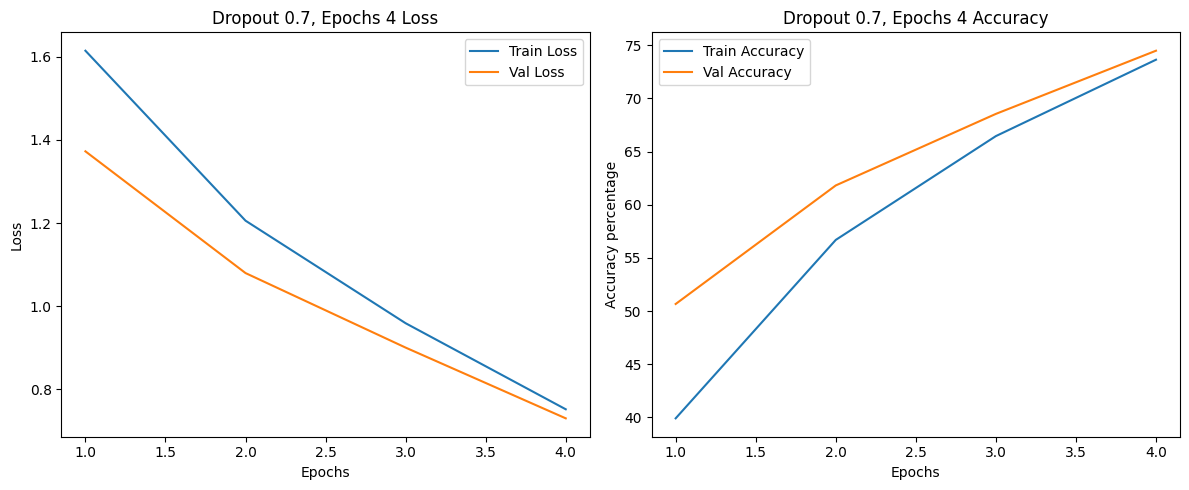

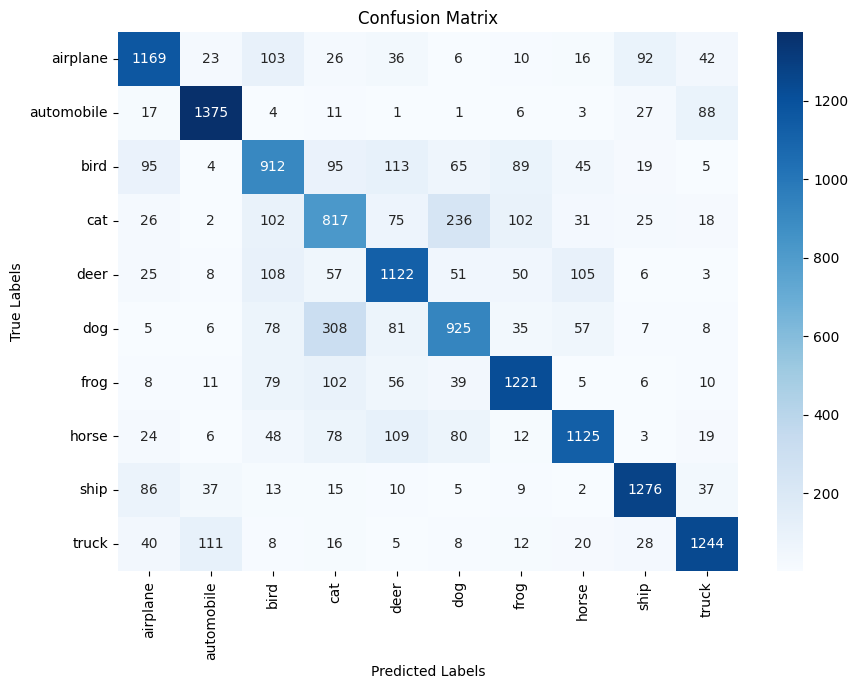

In [ ]:
train_test_mobilenetV3(dropout_rate=0.7, epochs=4, large=False)

If we add more epochs and we start to see early signs of overfitting. Below is an example where we add one more epoch

Small model

Epoch 1, Train Loss: 1.5704334651748266, Valid Loss: 1.2467546290539682, Train Accuracy: 41.082857142857144%, Valid Accuracy: 54.54%
Epoch 2, Train Loss: 1.1148745824039745, Valid Loss: 0.9795281291007996, Train Accuracy: 60.31428571428572%, Valid Accuracy: 65.22666666666667%
Epoch 3, Train Loss: 0.9071868147013175, Valid Loss: 0.8551464527211291, Train Accuracy: 67.83142857142857%, Valid Accuracy: 70.18%
Epoch 4, Train Loss: 0.7182797336818095, Valid Loss: 0.7066162479684708, Train Accuracy: 74.70285714285714%, Valid Accuracy: 75.16666666666667%
Epoch 5, Train Loss: 0.6735771781674686, Valid Loss: 0.6845357695792583, Train Accuracy: 76.4%, Valid Accuracy: 75.87333333333333%

Precision: 0.7572519955211746
Recall: 0.7602
Test Accuracy: 0.7602


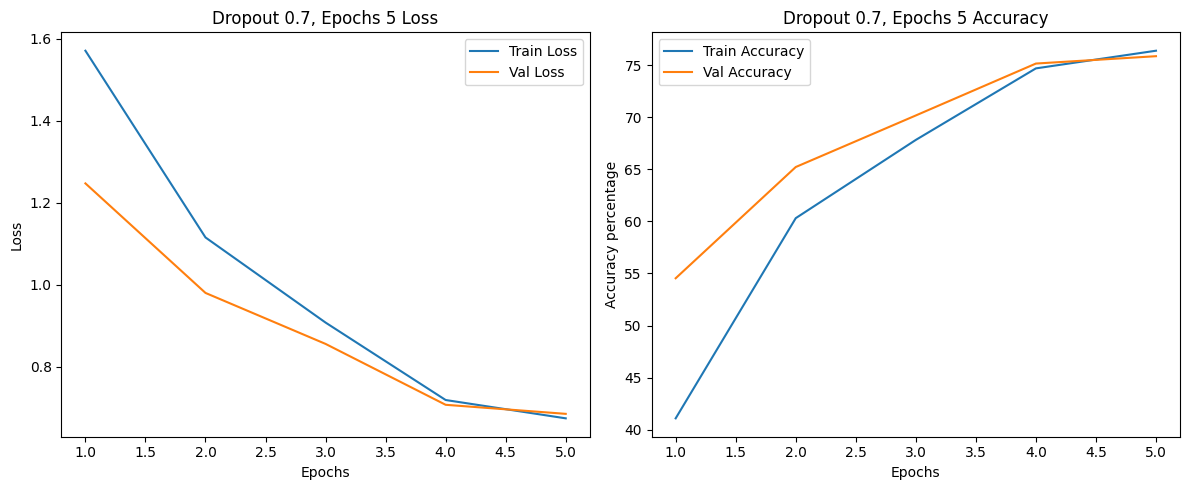

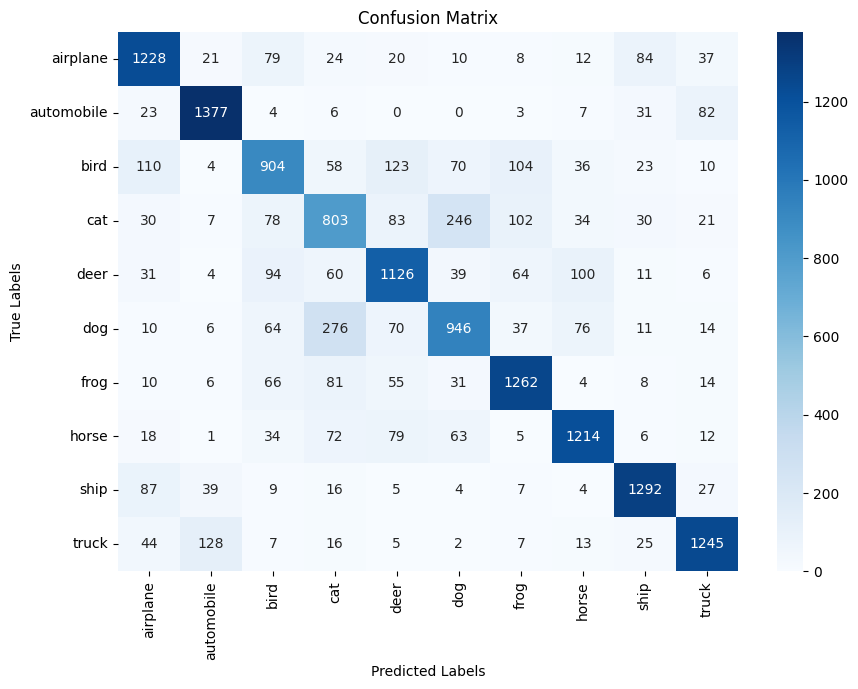

In [ ]:
train_test_mobilenetV3(dropout_rate=0.7, epochs=5, large=False)

### Engineered overfitting  
Here we are setting the dropout_rate to 0 and increase the epochs to engineer overfitting

Small model

Epoch 1, Train Loss: 1.53493206864955, Valid Loss: 1.263846637593939, Train Accuracy: 42.825714285714284%, Valid Accuracy: 53.60666666666667%
Epoch 2, Train Loss: 1.11026319234855, Valid Loss: 1.021451451676957, Train Accuracy: 59.95428571428572%, Valid Accuracy: 63.66%
Epoch 3, Train Loss: 0.9009133164908811, Valid Loss: 0.8275344416182092, Train Accuracy: 68.23428571428572%, Valid Accuracy: 70.88%
Epoch 4, Train Loss: 0.6958142811572094, Valid Loss: 0.7019429115538901, Train Accuracy: 75.40857142857143%, Valid Accuracy: 75.3%
Epoch 5, Train Loss: 0.6464055554849356, Valid Loss: 0.6799887706624701, Train Accuracy: 77.15428571428572%, Valid Accuracy: 75.94666666666667%
Epoch 6, Train Loss: 0.6287009514446015, Valid Loss: 0.6739682787276329, Train Accuracy: 77.82%, Valid Accuracy: 76.27333333333333%
Epoch 7, Train Loss: 0.6152434082092271, Valid Loss: 0.6623558530148039, Train Accuracy: 78.05714285714286%, Valid Accuracy: 76.40666666666667%
Epoch 8, Train Loss: 0.6115166582

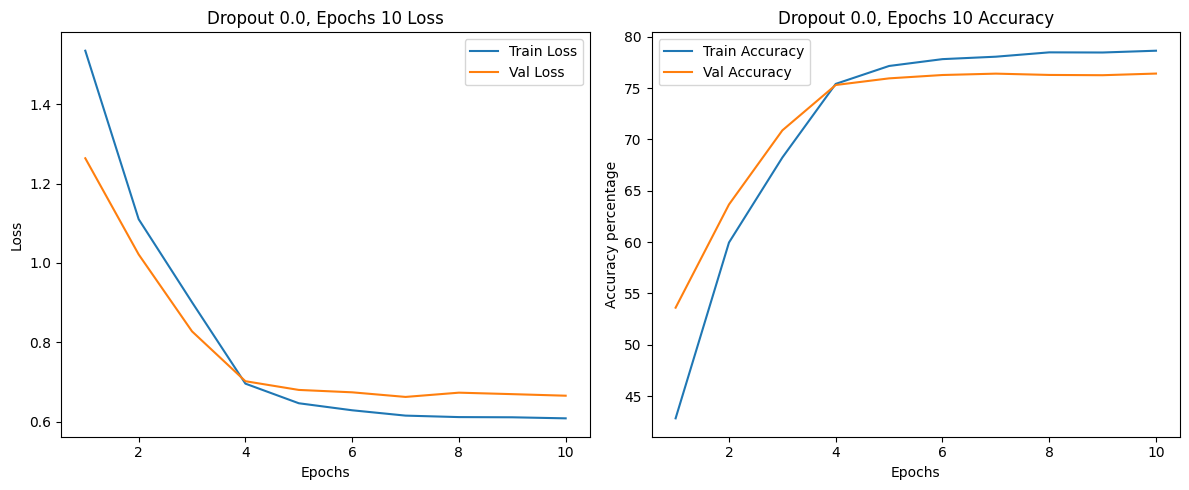

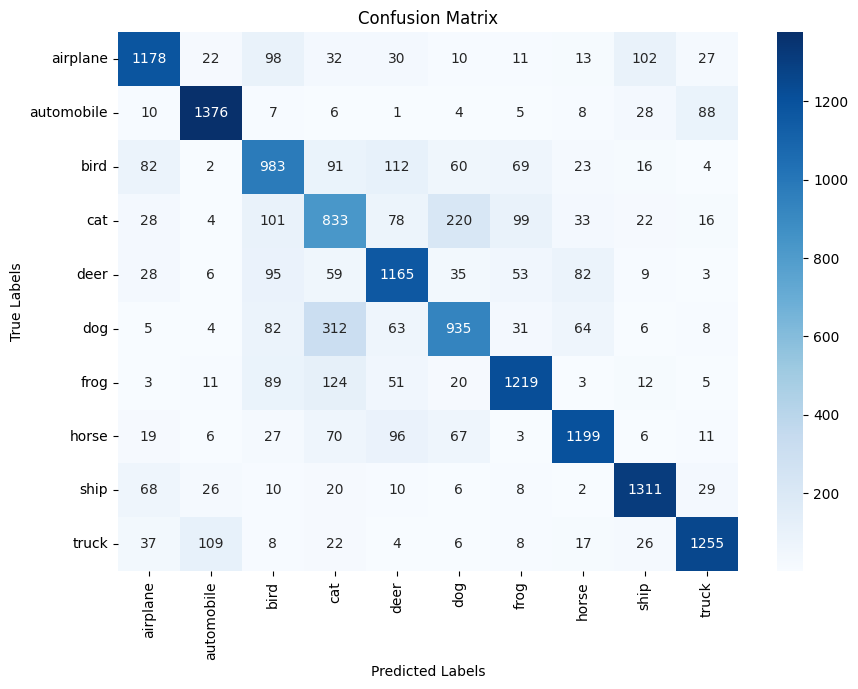

In [ ]:
train_test_mobilenetV3(dropout_rate=0.0, epochs=10, large=False)

### Engineered underfitting  
Here we are decreasing the number of epochs and increasing the dropout rate to engineer underfitting.

Small model

Epoch 1, Train Loss: 1.6710844833192704, Valid Loss: 1.3093148781898174, Train Accuracy: 37.73714285714286%, Valid Accuracy: 51.54%
Epoch 2, Train Loss: 1.228706557201511, Valid Loss: 1.0436592523087846, Train Accuracy: 56.25714285714286%, Valid Accuracy: 63.07333333333333%
Epoch 3, Train Loss: 1.0155717436312757, Valid Loss: 0.8687970341520107, Train Accuracy: 64.37142857142857%, Valid Accuracy: 69.22%

Precision: 0.6941715863943863
Recall: 0.693
Test Accuracy: 0.6930


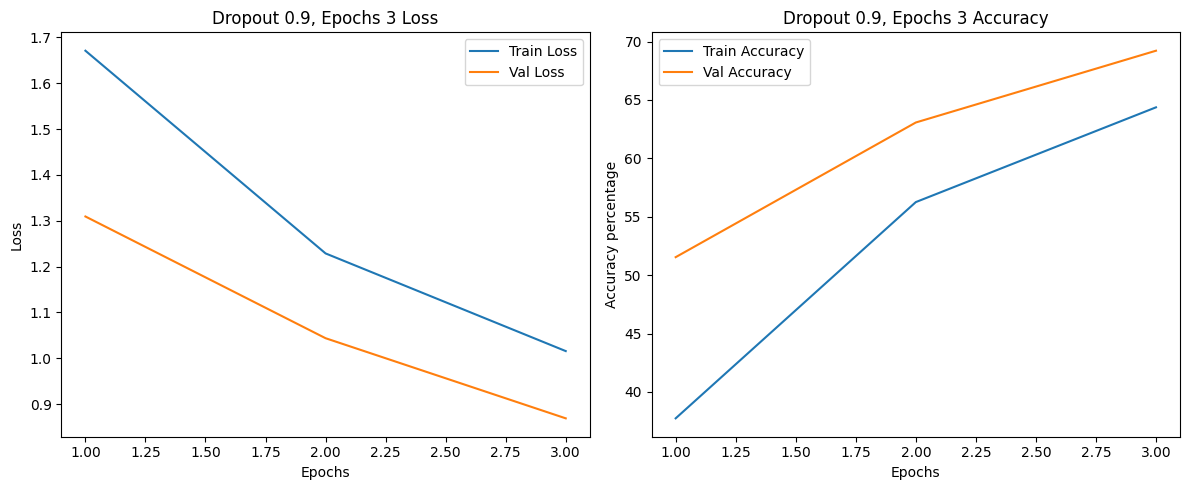

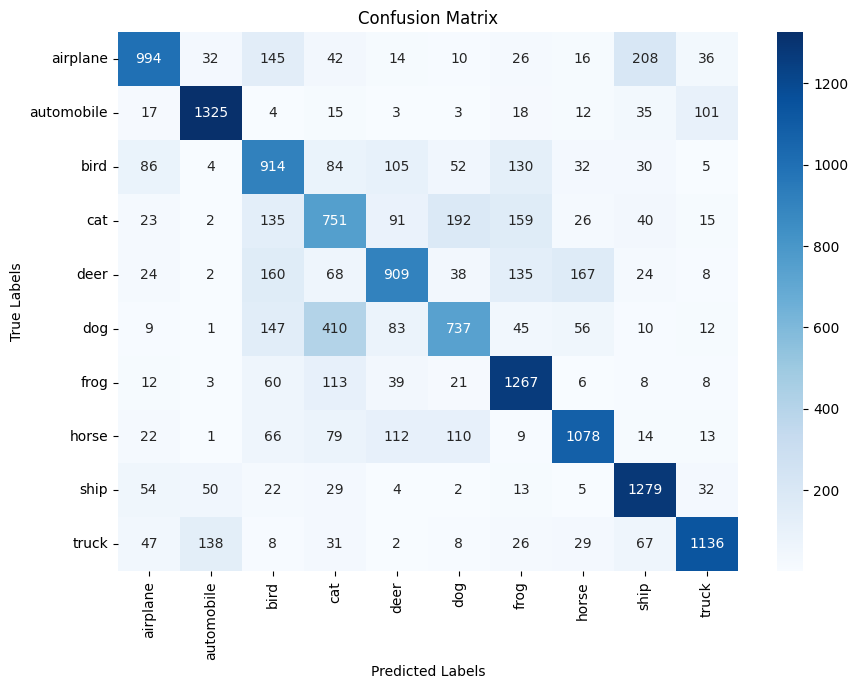

In [ ]:
train_test_mobilenetV3(dropout_rate=0.9, epochs=3, large=False)

## The Large Model
In this case we are running the same set of hyperparameter combinations that we applied to the small model to see if the size of the model makes a difference when applying these overfitting and underfitting simulations.

Large model

Epoch 1, Train Loss: 1.6218354736865113, Valid Loss: 1.3248554660918865, Train Accuracy: 38.99142857142857%, Valid Accuracy: 51.60666666666667%
Epoch 2, Train Loss: 1.1703722701430104, Valid Loss: 1.047672409960564, Train Accuracy: 58.09142857142857%, Valid Accuracy: 62.32%
Epoch 3, Train Loss: 0.933303808599329, Valid Loss: 0.850657362253108, Train Accuracy: 67.44%, Valid Accuracy: 70.28%
Epoch 4, Train Loss: 0.7144098136934981, Valid Loss: 0.686813800766113, Train Accuracy: 75.0%, Valid Accuracy: 75.64%

Precision: 0.7624977661099234
Recall: 0.7618
Test Accuracy: 0.7618


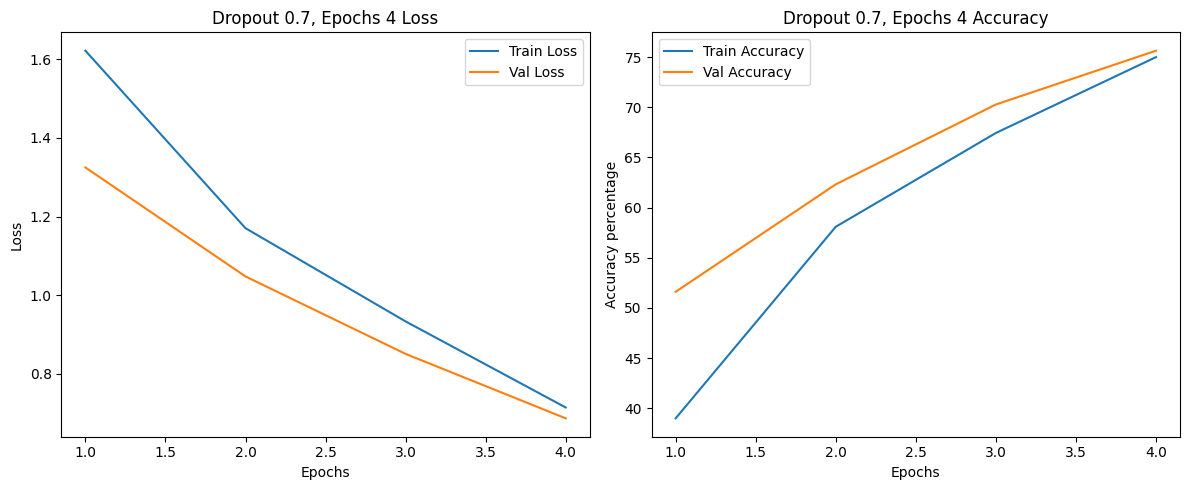

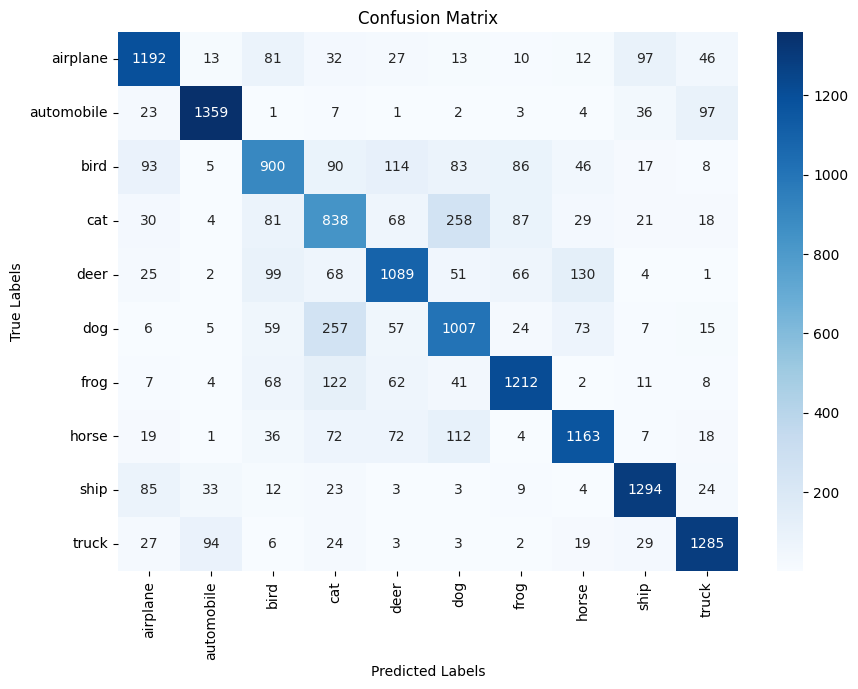

In [ ]:
train_test_mobilenetV3(dropout_rate=0.7, epochs=4, large=True)

Large model

Epoch 1, Train Loss: 1.6268672173812142, Valid Loss: 1.3770692493053194, Train Accuracy: 39.15714285714286%, Valid Accuracy: 50.86%
Epoch 2, Train Loss: 1.1860696499046939, Valid Loss: 1.0624397523859714, Train Accuracy: 57.317142857142855%, Valid Accuracy: 62.38666666666666%
Epoch 3, Train Loss: 0.9246694099096755, Valid Loss: 0.8188843387238522, Train Accuracy: 67.36857142857143%, Valid Accuracy: 70.51333333333334%
Epoch 4, Train Loss: 0.694356041373021, Valid Loss: 0.6753340481443608, Train Accuracy: 75.70571428571428%, Valid Accuracy: 76.06666666666666%
Epoch 5, Train Loss: 0.6491570534283326, Valid Loss: 0.6496538230713378, Train Accuracy: 77.31714285714285%, Valid Accuracy: 77.12%

Precision: 0.7726209060673617
Recall: 0.7745999999999998
Test Accuracy: 0.7746


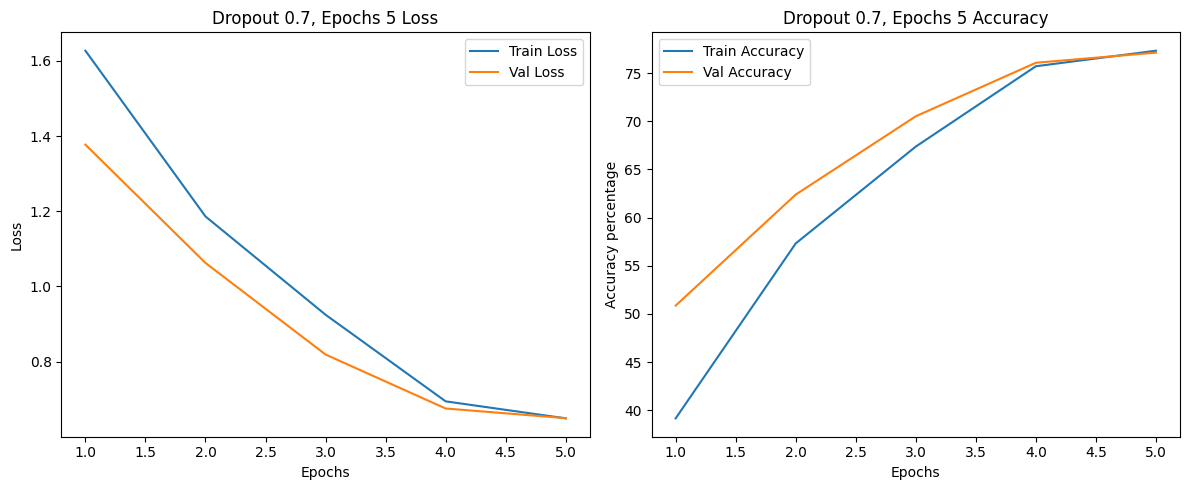

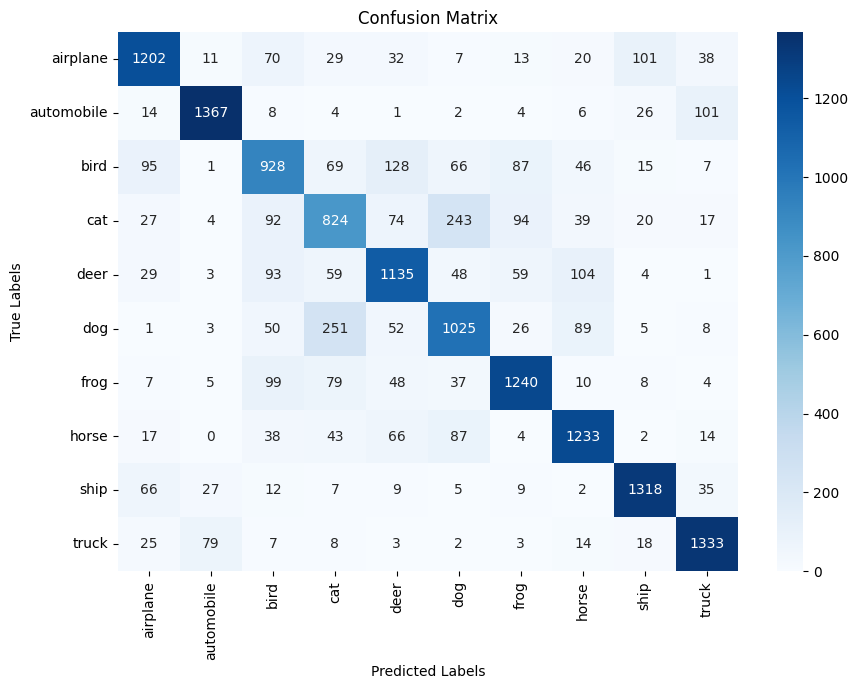

In [ ]:
train_test_mobilenetV3(dropout_rate=0.7, epochs=5, large=True)

### Engineered overfitting

Large model

Epoch 1, Train Loss: 1.559942543179723, Valid Loss: 1.3250556103726652, Train Accuracy: 42.06285714285714%, Valid Accuracy: 51.553333333333335%
Epoch 2, Train Loss: 1.1151407301099034, Valid Loss: 1.0289645935626741, Train Accuracy: 59.74285714285714%, Valid Accuracy: 63.4%
Epoch 3, Train Loss: 0.8871865954651911, Valid Loss: 0.8540456977296382, Train Accuracy: 68.72571428571429%, Valid Accuracy: 69.55333333333333%
Epoch 4, Train Loss: 0.6680058050744059, Valid Loss: 0.6557058582914637, Train Accuracy: 76.63142857142857%, Valid Accuracy: 76.96666666666667%
Epoch 5, Train Loss: 0.609639893393194, Valid Loss: 0.6382015896604416, Train Accuracy: 78.52571428571429%, Valid Accuracy: 77.68%
Epoch 6, Train Loss: 0.5826207103524391, Valid Loss: 0.6162643030602881, Train Accuracy: 79.29142857142857%, Valid Accuracy: 78.32666666666667%
Epoch 7, Train Loss: 0.5660904794114163, Valid Loss: 0.6138739106502938, Train Accuracy: 80.1%, Valid Accuracy: 78.44%
Epoch 8, Train Loss: 0.5645828

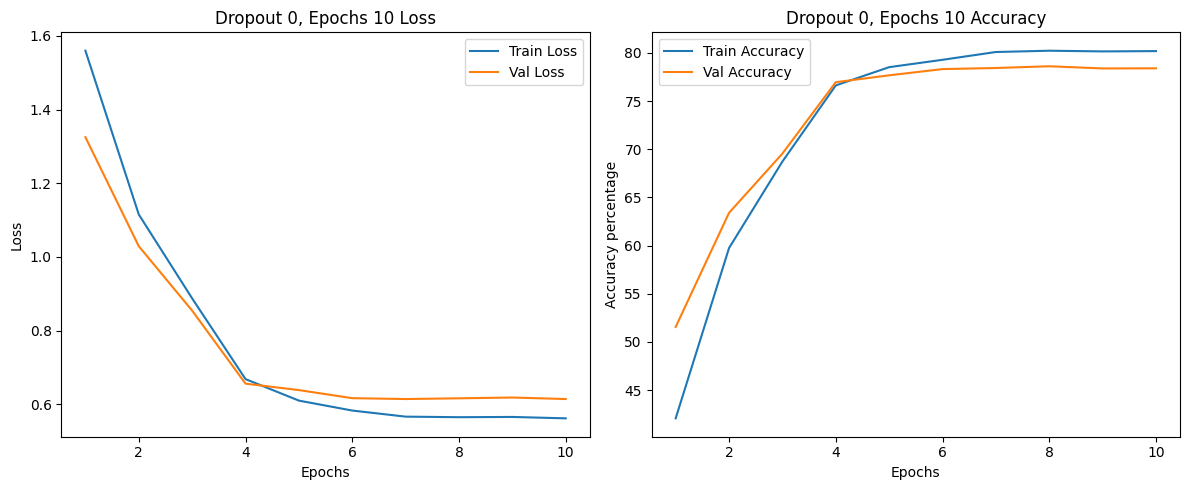

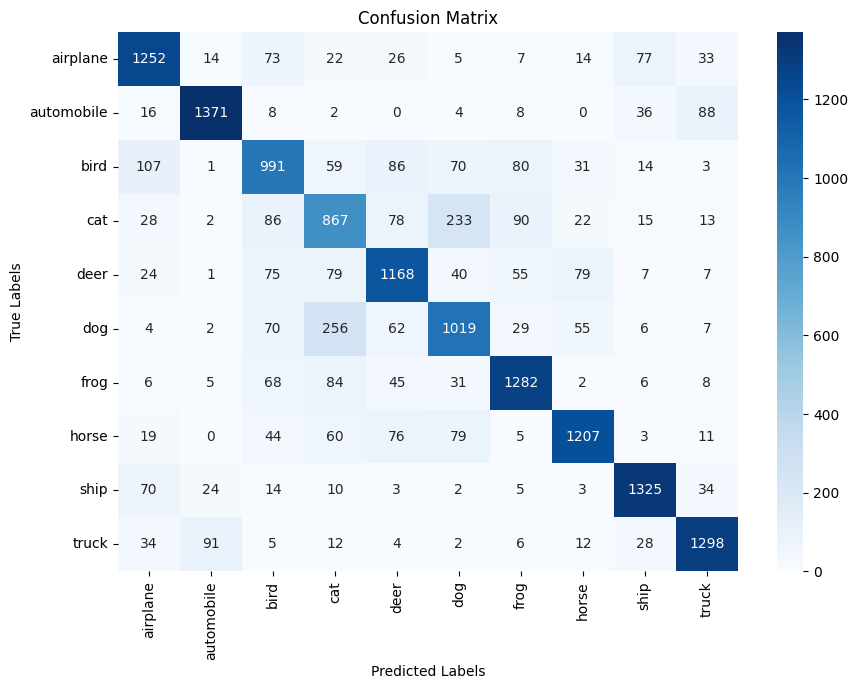

In [ ]:
train_test_mobilenetV3(dropout_rate=0, epochs=10, large=True)

### Engineered underfitting

Large model

Epoch 1, Train Loss: 1.7276844525032113, Valid Loss: 1.4075696782862885, Train Accuracy: 34.12285714285714%, Valid Accuracy: 46.70666666666666%
Epoch 2, Train Loss: 1.2767921078139728, Valid Loss: 1.0767401482196564, Train Accuracy: 53.97714285714286%, Valid Accuracy: 61.21333333333333%
Epoch 3, Train Loss: 0.9997519236160153, Valid Loss: 0.8543776377718499, Train Accuracy: 65.15714285714286%, Valid Accuracy: 70.32%

Precision: 0.7105702294239662
Recall: 0.7094
Test Accuracy: 0.7094


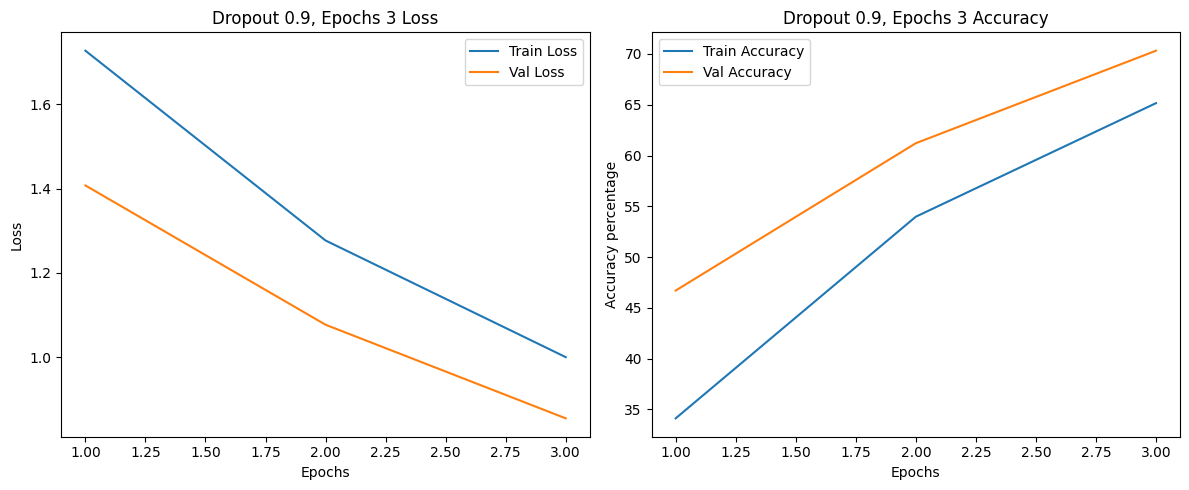

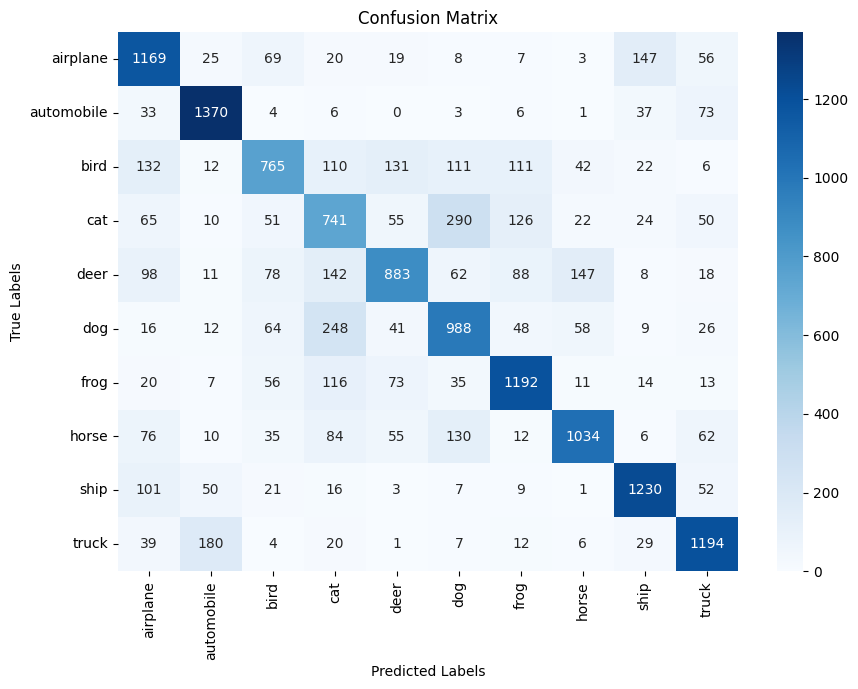

In [ ]:
train_test_mobilenetV3(dropout_rate=0.9, epochs=3, large=True)